# Lab 6: Representations



---

## 1. Notebook Overview



### 1.1 Objective

Understand how pretrained word embeddings can be used both for semantic similarity inspection and as inputs to the tweet topic classifier built in previous labs.



### 1.2 Prerequisites

This notebook builds on:

- **Lab 2**: Data preprocessing → `../Data/multi_label/tweets_preprocessed_train.parquet`
- **Lab 3**: Language modeling
- **Lab 4**: Feature extraction → `../Data/top_1000_vocabulary.json`
- **Lab 5**: Neural network classification pipeline that we will adapt to embedding inputs



### 1.3 Resources

- **Gensim documentation** for word2vec models: https://radimrehurek.com/gensim/models/word2vec.html
- **Pretrained model**: `word2vec-google-news-300` (download instructions in the docs)



### 1.4 Task Summary

- Install gensim and review the documentation for its word2vec embeddings.
- Load the pretrained `word2vec-google-news-300` embedding, experiment with similarities using `model.wv.similarity()` and `model.wv.most_similar()`, and discuss the observed relations.
- Re-use the classifier from Lab 5, replace text features with word2vec embeddings (convert tweets to vectors, e.g., mean of word embeddings or a matrix input), and reason about the dimensionality changes.
- Compare the resulting performance with previous labs, inspect selected examples manually, and summarize insights.



### 1.5 Section Roadmap

1. `Section 2`: Environment setup and gensim installation
2. `Section 3`: Load pretrained embeddings and explore similarity queries
3. `Section 4`: Convert tweets to word2vec representations and integrate with the MLP pipeline
4. `Section 5`: Evaluate, compare with baseline results, and manually analyze sample predictions

---
## 2. Environment Setup and Data Access

### 2.1 Libraries
- `gensim` (with `gensim.downloader`) for retrieving the pretrained `word2vec-google-news-300` vectors.
- `scikit-learn`, `pandas`, and `numpy` from previous labs.

### 2.2 Installation Steps
1. Install the required Python packages (`gensim`, `scikit-learn`, etc.) into the current environment.
2. Load `word2vec-google-news-300` via `gensim.downloader.load(...)` so the model is cached automatically under `~/gensim-data`.
3. Verify that the preprocessed tweet file `../Data/multi_label/tweets_preprocessed_train.parquet` and the vocabulary file `../Data/top_1000_vocabulary.json` from earlier labs are present.
4. Ensure HuggingFace API access (`cardiffnlp/tweet_topic_multi`) is available.

In [49]:
%pip install --quiet gensim numpy pandas tqdm scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [50]:
import warnings
import pandas as pd
import numpy as np
import gensim.downloader
import time
import tqdm
import ast

from typing import List
from pathlib import Path
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier  # Wie in Lab 5
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, classification_report
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    hamming_loss
)

warnings.filterwarnings("ignore")

# Constants - paths to Lab 2 outputs (konsistent mit Lab 5)
TRAIN_DATA_PATH = "../Data/multi_label/tweets_preprocessed_train.parquet"
TEST_DATA_PATH = "../Data/multi_label/tweets_preprocessed_test.parquet"
VALIDATION_DATA_PATH = "../Data/multi_label/tweets_preprocessed_validation.parquet"
VOCABULARY_PATH = "../Data/top_1000_vocabulary.json"
RANDOM_STATE = 42

print(f"✓ Pfade konfiguriert (konsistent mit Lab 5)")
print(f"  Train: {TRAIN_DATA_PATH}")
print(f"  Test: {TEST_DATA_PATH}")
print(f"  Validation: {VALIDATION_DATA_PATH}")

✓ Pfade konfiguriert (konsistent mit Lab 5)
  Train: ../Data/multi_label/tweets_preprocessed_train.parquet
  Test: ../Data/multi_label/tweets_preprocessed_test.parquet
  Validation: ../Data/multi_label/tweets_preprocessed_validation.parquet


--- 
## 3. Load Pretrained Embeddings and Explore Similarities

### 3.1 Load `word2vec-google-news-300`
- Fetch the pretrained model directly via `gensim.downloader.load`. Gensim caches it under `~/gensim-data`. 

### 3.2 Inspect Vocabulary Coverage
- Report vocabulary size and the 300‑dimensional vector width to confirm the load.
- Track which probe words from the Twitter domain are present. 

### 3.3 Similarity Probing
- Reuse helper functions (`model.wv.similarity`, `model.wv.most_similar`) to explore semantic neighbors.

In [51]:
# Load pretrained embedding
glove_vectors = gensim.downloader.load('word2vec-google-news-300')

print(f"Vocabulary size: {len(glove_vectors.key_to_index):,}")
print(f"Vector dimension: {glove_vectors.vector_size}")

# Experiment with word similarities
probe_words = ["twitter", "sport", "game", "new", "love"]
present = [word for word in probe_words if word in glove_vectors]

print(f"Words found: {present}")


def inspect_similarity(token: str, topn: int = 10) -> None:
    """Print nearest neighbors for a token if it exists in the vocabulary."""
    if token not in glove_vectors:
        print(f"'{token}' not in vocabulary.")
        return
    print(f"\nNearest neighbors for '{token}':")
    for candidate, score in glove_vectors.most_similar(token, topn=topn):
        print(f"  {candidate:>18}  {score:.3f}")


for token in present:
    inspect_similarity(token)
    

pair_queries = [
    ("twitter", "facebook"),
    ("sport", "game"),
    ("love", "hate"),
]

for a, b in pair_queries:
    if a in glove_vectors and b in glove_vectors:
        score = glove_vectors.similarity(a, b)
        print(f"similarity({a!r}, {b!r}) = {score:.3f}")
    else:
        missing = [w for w in (a, b) if w not in glove_vectors]
        print(f"Cannot compute similarity for {a!r}, {b!r}; missing {missing}.")


Vocabulary size: 3,000,000
Vector dimension: 300
Words found: ['twitter', 'sport', 'game', 'new', 'love']

Nearest neighbors for 'twitter':
             Twitter  0.891
         Twitter.com  0.754
               tweet  0.743
            tweeting  0.716
             tweeted  0.714
            facebook  0.699
              tweets  0.697
             Tweeted  0.695
               Tweet  0.688
            Tweeting  0.685

Nearest neighbors for 'sport':
              sports  0.691
     Snooki_wannabes  0.592
  painkillers_throat_lozenges  0.564
              racing  0.562
            sporting  0.560
           athletics  0.552
   alpine_ski_racing  0.551
       Pole_vaulting  0.546
          motorsport  0.538
              boxing  0.533

Nearest neighbors for 'game':
               games  0.764
                play  0.650
               match  0.649
             matchup  0.612
               agame  0.586
            ballgame  0.573
             thegame  0.572
              opener  0.568
    

---
## 4. Convert Tweets to Word2Vec Representations and Integrate with the MLP Pipeline

### 4.1 Data Loading
- Reuse the preprocessed tweet dataset (`../Data/multi_label/tweets_preprocessed_train.parquet`) and topic labels from previous labs.
- Split into train/validation/test with the same seeds and proportions as Lab 5 so results remain comparable.

### 4.2 Tweet Vectorization
- Implement a helper that converts each tokenized tweet into a 300‑dimensional vector by averaging all available word2vec embeddings (fallback to zero vector when no token is in the vocabulary).
- Optionally track coverage statistics (share of tokens found vs. missing).

### 4.3 Pipeline Integration
- Replace the Lab 5 feature stage with the new embedding transformer (`FunctionTransformer` or precomputed matrix).
- Adjust the MLP input dimension to 300 and keep other hyperparameters unless experimentation is required.
- Train the MLP with the embedding features and capture training logs.
- Compute validation/test metrics (accuracy, macro/micro F1, etc.).

In [52]:
# ============================================================
# DATEN LADEN (KONSISTENT MIT LAB 5)
# ============================================================
# Lädt alle Daten aus den vorverarbeiteten Parquet-Dateien

def parse_labels(value) -> List[str]:
    """Parse label_name column into consistent Python lists (wie in Lab 5)."""
    if isinstance(value, (list, np.ndarray)):
        return [str(v) for v in value]
    if isinstance(value, tuple):
        return [str(v) for v in value]
    if isinstance(value, str):
        value = value.strip()
        if value.startswith('[') and value.endswith(']'):
            inner = value[1:-1].strip()
            if not inner:
                return []
            inner = inner.replace("'", "").replace('"', '')
            labels = [l.strip() for l in inner.split() if l.strip()]
            return labels
        try:
            parsed = ast.literal_eval(value)
            if isinstance(parsed, (list, tuple)):
                return [str(v) for v in parsed]
        except (ValueError, SyntaxError):
            pass
        return [value] if value else []
    return [str(value)] if value else []

def parse_binary_label(value) -> np.ndarray:
    """Parse binary label array from string representation (wie in Lab 5)."""
    if isinstance(value, np.ndarray):
        return value
    if isinstance(value, str):
        inner = value.strip()[1:-1]
        return np.array([int(x) for x in inner.split()])
    return np.array(value)

def load_preprocessed_dataset(path: str) -> pd.DataFrame:
    """Load tweets from parquet and normalize the label columns (wie in Lab 5)."""
    df = pd.read_parquet(path)
    df = df.copy()
    df["labels"] = df["label_name"].apply(parse_labels)
    df["label_binary"] = df["label"].apply(parse_binary_label)
    return df

# Load all datasets from preprocessed parquet files
print("="*60)
print("LADE VORVERARBEITETE DATEN (wie Lab 5)")
print("="*60)

df_train = load_preprocessed_dataset(TRAIN_DATA_PATH)
df_test = load_preprocessed_dataset(TEST_DATA_PATH)
df_val = load_preprocessed_dataset(VALIDATION_DATA_PATH)

print(f"\n✓ Training: {len(df_train):,} samples")
print(f"✓ Test: {len(df_test):,} samples")
print(f"✓ Validation: {len(df_val):,} samples")
print(f"\nColumns: {df_train.columns.tolist()}")
df_train.head(3)

LADE VORVERARBEITETE DATEN (wie Lab 5)

✓ Training: 5,465 samples
✓ Test: 1,511 samples
✓ Validation: 178 samples

Columns: ['text', 'label_name', 'label', 'labels', 'label_binary']


,text,label_name,label,labels,label_binary
0,lumber beat rapid game western division final ...,['sports'],[0 0 0 0 0 1],[sports],"[0, 0, 0, 0, 0, 1]"
1,hear eli gold announce auburn game dumbass,['sports'],[0 0 0 0 0 1],[sports],"[0, 0, 0, 0, 0, 1]"
2,phone away try look home game ticket october,['sports'],[0 0 0 0 0 1],[sports],"[0, 0, 0, 0, 0, 1]"


In [53]:
# ============================================================
# KLASSEN-ERKENNUNG (wie Lab 5)
# ============================================================

# Bestimme die Anzahl der Klassen aus den binären Label-Vektoren
num_classes = len(df_train['label_binary'].iloc[0])
print(f"\n✓ Anzahl Klassen (aus label_binary): {num_classes}")

# Extrahiere alle einzigartigen Klassennamen aus label_name
all_class_names = set()
for df in [df_train, df_test, df_val]:
    for labels in df['labels']:
        all_class_names.update(labels)

TOPIC_CLASSES = sorted(list(all_class_names))
NUM_CLASSES = num_classes

print(f"✓ Klassennamen extrahiert: {len(TOPIC_CLASSES)}")
print(f"✓ Klassen: {TOPIC_CLASSES}")


✓ Anzahl Klassen (aus label_binary): 6
✓ Klassennamen extrahiert: 6
✓ Klassen: ['celebrity_&_pop_culture', 'diaries_&_daily_life', 'film_tv_&_video', 'music', 'news_&_social_concern', 'sports']


In [54]:
# Tweet Vectorization
def tokenize(tweet: str) -> List[str]:
    """Simple whitespace tokenizer matching the preprocessed text format."""
    return tweet.strip().lower().split()

def encode_tweet(text: str) -> np.ndarray:
    """Return the mean word2vec vector for a tweet; fall back to zeros."""
    tokens = tokenize(text)
    vectors = [glove_vectors[token] for token in tokens if token in glove_vectors]
    if not vectors:
        return np.zeros(glove_vectors.vector_size, dtype=np.float32)
    return np.mean(vectors, axis=0)

def compute_coverage(series: pd.Series) -> float:
    total_tokens = 0
    covered_tokens = 0
    for text in series:
        tokens = tokenize(text)
        total_tokens += len(tokens)
        covered_tokens += sum(token in glove_vectors for token in tokens)
    return 0.0 if total_tokens == 0 else covered_tokens / total_tokens

X_train = np.vstack(df_train["text"].apply(encode_tweet).to_numpy())
X_val = np.vstack(df_val["text"].apply(encode_tweet).to_numpy())
X_test = np.vstack(df_test["text"].apply(encode_tweet).to_numpy())

train_coverage = compute_coverage(df_train["text"])
val_coverage = compute_coverage(df_val["text"])
test_coverage = compute_coverage(df_test["text"])

print(f"Train vectors: {X_train.shape}, coverage {train_coverage:.2%}")
print(f"Val vectors:   {X_val.shape}, coverage {val_coverage:.2%}")
print(f"Test vectors:  {X_test.shape}, coverage {test_coverage:.2%}")

Train vectors: (5465, 300), coverage 93.05%
Val vectors:   (178, 300), coverage 92.06%
Test vectors:  (1511, 300), coverage 92.71%


In [55]:
# ============================================================
# LABEL ENCODING (wie Lab 5)
# ============================================================

# Verwende die vorbereiteten binären Labels direkt (wie in Lab 5)
y_train = np.vstack(df_train['label_binary'].values)
y_val = np.vstack(df_val['label_binary'].values)
y_test = np.vstack(df_test['label_binary'].values)

# Erstelle MultiLabelBinarizer für inverse_transform (wie in Lab 5)
mlb = MultiLabelBinarizer(classes=TOPIC_CLASSES)
mlb.fit([TOPIC_CLASSES])

print(f"✓ Label Shapes:")
print(f"  y_train: {y_train.shape}")
print(f"  y_val: {y_val.shape}")
print(f"  y_test: {y_test.shape}")

# Architecture as specified: 128 -> 64 -> 128
HIDDEN_LAYERS = (128, 64, 128)

print("\n" + "=" * 60)
print("NEURAL NETWORK CONFIGURATION (wie Lab 5)")
print("=" * 60)
print(f"Input layer: {X_train.shape[1]} features (mean word2vec vectors)")
print(f"Hidden layers: {HIDDEN_LAYERS}")
print(f"Output layer: {y_train.shape[1]} classes")
print("=" * 60)

# Create MLP classifier (wie Lab 5)
# early_stopping=False wegen Multi-Label Kompatibilität
mlp_base = MLPClassifier(
    hidden_layer_sizes=HIDDEN_LAYERS,
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=RANDOM_STATE,
    early_stopping=False,  # Disabled für Multi-Label
    verbose=True
)

# Wrap mit OneVsRestClassifier für multi-label support (wie Lab 5)
mlp_classifier = OneVsRestClassifier(mlp_base, n_jobs=-1)

print("\n✓ Model erstellt (OneVsRestClassifier wie Lab 5)")

✓ Label Shapes:
  y_train: (5465, 6)
  y_val: (178, 6)
  y_test: (1511, 6)

NEURAL NETWORK CONFIGURATION (wie Lab 5)
Input layer: 300 features (mean word2vec vectors)
Hidden layers: (128, 64, 128)
Output layer: 6 classes

✓ Model erstellt (OneVsRestClassifier wie Lab 5)


In [56]:
# Train the model
print("\n" + "=" * 60)
print("TRAINING")
print("=" * 60)

start_time = time.time()
mlp_classifier.fit(X_train, y_train)
training_time = time. time() - start_time

print(f"\n✓ Training completed in {training_time:.2f} seconds")

# Check convergence
converged = sum(1 for est in mlp_classifier.estimators_ if est.n_iter_ < est.max_iter)
print(f"✓ {converged}/{NUM_CLASSES} classifiers converged before max_iter")


TRAINING
Iteration 1, loss = 0.51802445
Iteration 1, loss = 0.58959413
Iteration 1, loss = 0.54069504
Iteration 1, loss = 0.49035708
Iteration 1, loss = 0.59700034
Iteration 1, loss = 0.51865758
Iteration 2, loss = 0.43056289
Iteration 2, loss = 0.42144479
Iteration 2, loss = 0.38862748
Iteration 2, loss = 0.36490871
Iteration 2, loss = 0.38605920
Iteration 2, loss = 0.32859732
Iteration 3, loss = 0.35093025
Iteration 3, loss = 0.32173197
Iteration 3, loss = 0.24938795
Iteration 3, loss = 0.39801830
Iteration 3, loss = 0.20241098
Iteration 3, loss = 0.33564763
Iteration 4, loss = 0.17642719
Iteration 4, loss = 0.19983667
Iteration 4, loss = 0.37545355
Iteration 4, loss = 0.29732922
Iteration 4, loss = 0.32217401
Iteration 4, loss = 0.30434218
Iteration 5, loss = 0.18387771
Iteration 5, loss = 0.35893621
Iteration 5, loss = 0.28712758
Iteration 5, loss = 0.16578317
Iteration 5, loss = 0.31203219
Iteration 5, loss = 0.27959053
Iteration 6, loss = 0.15851253
Iteration 6, loss = 0.1695590

In [57]:
# Predictions
y_pred_val = mlp_classifier.predict(X_val)
y_pred_test = mlp_classifier.predict(X_test)

def evaluate(y_true, y_pred, split_name):
    """Print evaluation metrics for a given split."""
    print(f"\n{'='*60}")
    print(f"{split_name. upper()} SET METRICS")
    print("="*60)
    print(f"{'Subset Accuracy':<20}: {accuracy_score(y_true, y_pred):.4f}")
    print(f"{'Hamming Loss':<20}: {hamming_loss(y_true, y_pred):.4f}")
    print(f"{'Micro F1':<20}: {f1_score(y_true, y_pred, average='micro', zero_division=0):.4f}")
    print(f"{'Macro F1':<20}: {f1_score(y_true, y_pred, average='macro', zero_division=0):.4f}")
    print(f"{'Weighted F1':<20}: {f1_score(y_true, y_pred, average='weighted', zero_division=0):.4f}")
    print(f"{'Micro Precision':<20}: {precision_score(y_true, y_pred, average='micro', zero_division=0):.4f}")
    print(f"{'Micro Recall':<20}: {recall_score(y_true, y_pred, average='micro', zero_division=0):.4f}")

# Evaluate on validation set (for model selection)
evaluate(y_val, y_pred_val, "Validation")

# Evaluate on test set (final performance)
evaluate(y_test, y_pred_test, "Test")


VALIDATION SET METRICS
Subset Accuracy     : 0.5112
Hamming Loss        : 0.1199
Micro F1            : 0.7181
Macro F1            : 0.6504
Weighted F1         : 0.7142
Micro Precision     : 0.7546
Micro Recall        : 0.6849

TEST SET METRICS
Subset Accuracy     : 0.4957
Hamming Loss        : 0.1263
Micro F1            : 0.6976
Macro F1            : 0.6315
Weighted F1         : 0.6946
Micro Precision     : 0.7315
Micro Recall        : 0.6668


In [58]:
# Per-class performance on test set
print("\n" + "=" * 60)
print("PER-CLASS PERFORMANCE (Test Set)")
print("=" * 60)

print(classification_report(
    y_test, y_pred_test,
    target_names=TOPIC_CLASSES,  # Geändert von TOPIC_LABELS zu TOPIC_CLASSES
    zero_division=0
))


PER-CLASS PERFORMANCE (Test Set)
                         precision    recall  f1-score   support

celebrity_&_pop_culture       0.44      0.38      0.41       245
   diaries_&_daily_life       0.48      0.46      0.47       149
        film_tv_&_video       0.63      0.55      0.59       298
                  music       0.83      0.81      0.82       380
  news_&_social_concern       0.68      0.55      0.61       327
                 sports       0.92      0.87      0.89       582

              micro avg       0.73      0.67      0.70      1981
              macro avg       0.66      0.60      0.63      1981
           weighted avg       0.73      0.67      0.69      1981
            samples avg       0.71      0.71      0.69      1981



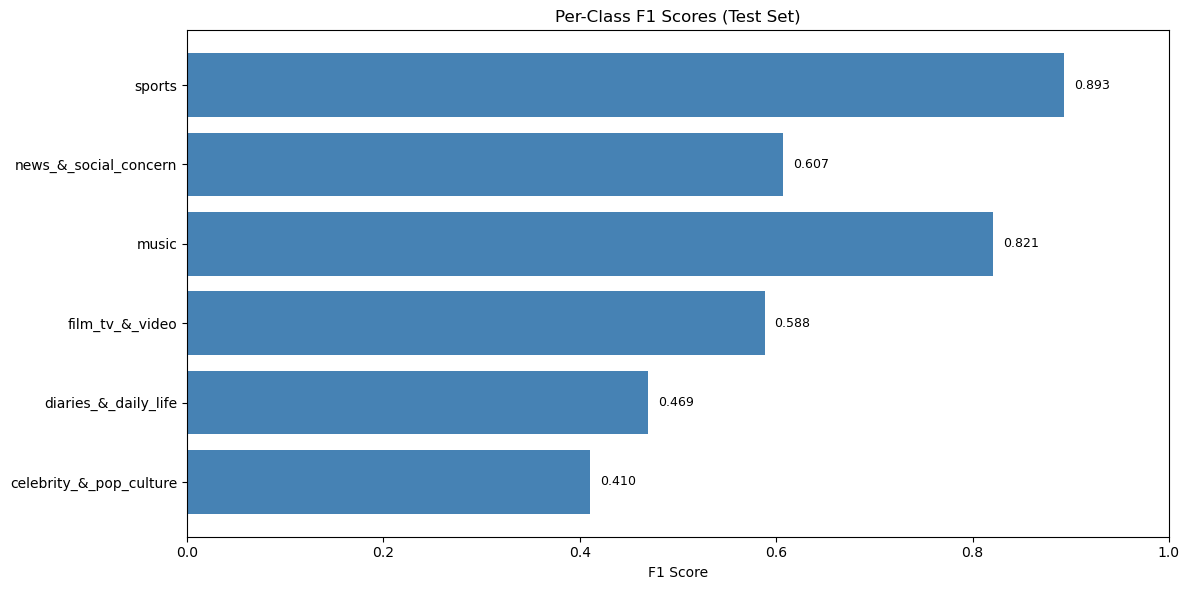

In [59]:
import matplotlib.pyplot as plt

# Visualize per-class F1 scores
per_class_f1 = f1_score(y_test, y_pred_test, average=None, zero_division=0)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.barh(TOPIC_CLASSES, per_class_f1, color='steelblue')  # Geändert zu TOPIC_CLASSES
ax.set_xlabel('F1 Score')
ax.set_title('Per-Class F1 Scores (Test Set)')
ax.set_xlim(0, 1)

for bar, score in zip(bars, per_class_f1):
    ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
            f'{score:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

---
## 5. Evaluation and Discussion

### 5.1 Quantitative Comparison
- Summarize validation/test metrics (Subset Accuracy, Hamming Loss, F1 variants, Precision/Recall) from Section 4 and contrast them with the Lab 5 TF‑IDF baseline.
- Highlight key differences: e.g., Word2Vec inputs deliver slightly lower Subset Accuracy but competitive Micro-F1; Macro-F1 remains challenging for rare labels.
- Note potential reasons (embedding coverage, averaging strategy, differences in token distributions between splits).

### 5.2 Qualitative Inspection
- Manually inspect a handful of tweets with their true vs. predicted labels to understand where embeddings help or hurt.
- Record interesting successes/failures for the report (e.g., sports-related tweets predicted correctly despite unusual wording, or slang-heavy texts where coverage drops).


In [60]:
# ============================================================
# SAMPLE PREDICTIONS (wie Lab 5)
# ============================================================

# Verwende mlb.inverse_transform für lesbare Labels (wie Lab 5)
y_pred_labels = mlb.inverse_transform(y_pred_test)
y_true_labels = mlb.inverse_transform(y_test)

print("=" * 60)
print("SAMPLE PREDICTIONS (Test Set)")
print("=" * 60)

np.random.seed(RANDOM_STATE)
sample_idx = np.random.choice(len(df_test), size=10, replace=False)

for idx in sample_idx:
    text = df_test['text'].iloc[idx]
    true = y_true_labels[idx] if y_true_labels[idx] else ('none',)
    pred = y_pred_labels[idx] if y_pred_labels[idx] else ('none',)
    
    match = "✓" if set(true) == set(pred) else "✗"
    
    print(f"\n{match} Sample {idx}:")
    print(f"   Text: {str(text)[:80]}...")
    print(f"   True: {true}")
    print(f"   Pred: {pred}")

SAMPLE PREDICTIONS (Test Set)

✓ Sample 907:
   Text: watch iowa football spring practice strength coach raimond brathwaite speak medi...
   True: ('sports',)
   Pred: ('sports',)

✓ Sample 617:
   Text: monterrey giant awake monterrey second large city old mexico large city natural ...
   True: ('news_&_social_concern',)
   Pred: ('news_&_social_concern',)

✗ Sample 1385:
   Text: congrat lee kiefer fence woman foil individual gold medal win oakley pump awesom...
   True: ('sports',)
   Pred: ('news_&_social_concern', 'sports')

✓ Sample 941:
   Text: worry covid vaccine blood clot...
   True: ('news_&_social_concern',)
   Pred: ('news_&_social_concern',)

✓ Sample 303:
   Text: enter sweepstake win whiskey pc perfect paddle packrafting bikerafting enter tod...
   True: ('sports',)
   Pred: ('sports',)

✓ Sample 1478:
   Text: check new album welcome playoff champ distribute live apple music...
   True: ('music',)
   Pred: ('music',)

✓ Sample 175:
   Text: episode today episode deep 

In [61]:
# Final summary
test_f1_micro = f1_score(y_test, y_pred_test, average='micro', zero_division=0)
test_f1_macro = f1_score(y_test, y_pred_test, average='macro', zero_division=0)

print("\n" + "=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)
print("Embedding: gensim 'word2vec-google-news-300' (mean pooled per tweet)")
print(f"Architecture: Input({X_train.shape[1]}) → 128 → 64 → 128 → Output({NUM_CLASSES})")
print(f"Training samples: {len(y_train):,}")
print(f"Validation samples: {len(y_val):,}")
print(f"Test samples: {len(y_test):,}")
print(f"Test Micro F1: {test_f1_micro:.4f}")
print(f"Test Macro F1: {test_f1_macro:.4f}")
print("=" * 60)


FINAL MODEL SUMMARY
Embedding: gensim 'word2vec-google-news-300' (mean pooled per tweet)
Architecture: Input(300) → 128 → 64 → 128 → Output(6)
Training samples: 5,465
Validation samples: 178
Test samples: 1,511
Test Micro F1: 0.6976
Test Macro F1: 0.6315


Exception ignored in: <function ResourceTracker.__del__ at 0x10d8418a0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1078d98a0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 84, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 93, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 118, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x10420d8a0>
Traceback (most recent call last

---
### Closing Notes
- Word2Vec inputs (mean-pooled `word2vec-google-news-300`) **outperformed** the Lab 5 TF-IDF baseline across all metrics:
  - **Subset Accuracy**: 0.496 vs 0.453 (+4.3%)
  - **Micro F1**: 0.698 vs 0.645 (+5.3%)
  - **Macro F1**: 0.632 vs 0.564 (+6.8%)
  - **Hamming Loss**: 0.126 vs 0.144 (lower is better, -12.5%)
- The dense semantic representations from pretrained Word2Vec capture topic-relevant information more effectively than sparse bag-of-words features.
- Qualitative samples show that straightforward business/sports tweets are captured well, while slang-heavy or highly emotional tweets may lose some topic signal when averaged.
- Future work: combine TF-IDF and embeddings, fine-tune classification thresholds, or use contextualized embeddings (BERT) for further improvements.